# In this notebook I will look at the full Bdot measurements of the all planes.

I will also check if taking the curl of the magnetic field recovers a current centered at the center of the circulation in the b field.  I will test schemes for locating the current centroid.

## Imports

In [25]:
import numpy as np
import scipy.optimize as opti
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.tri import Triangulation, LinearTriInterpolator
from scipy.optimize import curve_fit
from scipy import odr
from scipy.optimize import leastsq
from skimage.feature import peak_local_max
import scipy.ndimage as ndimage
import cPickle as pickle
from scipy.integrate import odeint
import visit_writer

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import sys
sys.path.append('/Users/vonderlinden2/rsx_analysis/writing_to_vtk/source')
import structured_3d_vtk as struc_3d

## Define convience function and load magnetic field data.

# Method 2: Integrate field lines off the max and fit circle to the field lines

## Define functions

In [4]:
def to_min(params, points):
    a = 2.*params[0]
    b = 2.*params[1]
    c = params[2]**2 - params[1]**2 - params[0]**2
    return a*points[0] + b*points[1] + c - points[0]**2 - points[1]**2

def calculate_radius(x, y, x_0, y_0):
    r"""
    Calculate radius.
    """
    return (x - x_0)**2 + (y - y_0)**2


def estimate_radius(data, x_0, y_0):
    r"""
    Estimate radius from data.
    """
    return calculate_radius(data[:, 0], data[:, 1], x_0, y_0).mean()

params_guess = [0, 0, 0.01]

In [22]:
def d_l(l, t, interpolator_x, interpolator_y):
    return np.asarray([interpolator_x([l[0], l[1]])[0], 
                       interpolator_y([l[0], l[1]])[0]])

def find_centroid(grid, bx_interpolator, by_interpolator, 
                  distance_thres=0.001, filter_size=5,
                  integration_length=10, integration_steps=100,
                  launch_point_step_factor=0.1, max_count=50):
    r"""
    """
    b_fields_x = bx_interpolator(grid[0][:, :], grid[1][:, :])
    b_fields_y = by_interpolator(grid[0][:, :], grid[1][:, :])
    b_fields = [b_fields_x, b_fields_y]
    x_min, x_max = grid[0].min(), grid[0].max()
    y_min, y_max = grid[1].min(), grid[1].max()
    magnitude = np.sqrt(b_fields[0][:, :]**2 + b_fields[1][:, :]**2)
    filtered_magnitude = ndimage.gaussian_filter(magnitude, filter_size)
    max_index = np.unravel_index(filtered_magnitude.argmax(), 
                                 filtered_magnitude.shape)
    
    center_points = []
    radii = []
    center_points = []
    streamlines = []
    direction = [0, 0]
    distance = 100
    launch_point = (grid[0][max_index], grid[1][max_index])
    count = 0
    while distance >= distance_thres:
        #print 'launch', launch_point
        #print distance
        t2 = np.linspace(0, integration_length, integration_steps)
        t1 = np.linspace(0, -integration_length, integration_steps)
        stream2 = odeint(d_l, launch_point, t2, args=(bx_interpolator, by_interpolator))
        stream1 = odeint(d_l, launch_point, t1, args=(bx_interpolator, by_interpolator))
        streamline = np.concatenate((stream1, stream2))
        size = streamline[np.invert(np.isnan(streamline))].size
        streamline = streamline[np.invert(np.isnan(streamline))].reshape(int(size/2.), 2)
        
        circle_params, success = leastsq(to_min, params_guess, args=np.asarray([streamline[:, 0], streamline[:, 1]]))
        direction = [circle_params[0] - launch_point[0], circle_params[1] - launch_point[1]]
        distance = np.sqrt(direction[0]**2. + direction[1]**2.)
        center_point = (circle_params[0], circle_params[1])
        launch_point = [launch_point[0] + direction[0] * launch_point_step_factor,
                        launch_point[1] + direction[1] * launch_point_step_factor]
        center_points.append(center_point)
        #print 'center', center_point
        radii.append(circle_params[0])
        streamlines.append(streamline)
        if (launch_point[0] <= x_min or
            launch_point[0] >= x_max or
            launch_point[1] <= y_min or 
            launch_point[1] >= y_max or
            count > max_count):
            break
        count += 1
    centroid = center_point
    return centroid, center_points, radii, streamlines, max_index

# Do it for all planes

In [12]:
meshes_0249 = np.load('../output/2016-08-06/B_z_0249_' + '0000' + '.npz')
meshes_0249['grid'].shape

(2, 54, 82)

In [19]:
grid_0249[0][:,:]

array([[-0.028, -0.028, -0.028, ..., -0.028, -0.028, -0.028],
       [-0.027, -0.027, -0.027, ..., -0.027, -0.027, -0.027],
       [-0.026, -0.026, -0.026, ..., -0.026, -0.026, -0.026],
       ..., 
       [ 0.023,  0.023,  0.023, ...,  0.023,  0.023,  0.023],
       [ 0.024,  0.024,  0.024, ...,  0.024,  0.024,  0.024],
       [ 0.025,  0.025,  0.025, ...,  0.025,  0.025,  0.025]])

In [23]:
centroids_0249 = []
centroids_0302 = []
centroids_0357 = []
centroids_0416 = []

meshes_0249 = np.load('../output/2016-08-06/B_z_0249_' + '0000' + '.npz')
grid_0249 = meshes_0249['grid']

meshes_0302 = np.load('../output/2016-08-06/B_z_0302_' + '0000' + '.npz')
grid_0302 = meshes_0302['grid']

meshes_0357 = np.load('../output/2016-08-06/B_z_0357_' + '0000' + '.npz')
grid_0357 = meshes_0357['grid']

meshes_0416 = np.load('../output/2016-08-06/B_z_0416_' + '0000' + '.npz')
grid_0416 = meshes_0416['grid']

for time_point in xrange(21):
    print time_point
    
    bx_0249_interpolator = pickle.load(open('../output/2016-08-06/B_z_0249_x_' + str(time_point).zfill(4) + '.p', 'rb'))
    by_0249_interpolator = pickle.load(open('../output/2016-08-06/B_z_0249_y_' + str(time_point).zfill(4) + '.p', 'rb'))
    
    bx_0302_interpolator = pickle.load(open('../output/2016-08-06/B_z_0302_x_' + str(time_point).zfill(4) + '.p', 'rb'))
    by_0302_interpolator = pickle.load(open('../output/2016-08-06/B_z_0302_y_' + str(time_point).zfill(4) + '.p', 'rb'))
    
    bx_0357_interpolator = pickle.load(open('../output/2016-08-06/B_z_0357_x_' + str(time_point).zfill(4) + '.p', 'rb'))
    by_0357_interpolator = pickle.load(open('../output/2016-08-06/B_z_0357_y_' + str(time_point).zfill(4) + '.p', 'rb'))
    
    bx_0416_interpolator = pickle.load(open('../output/2016-08-06/B_z_0416_x_' + str(time_point).zfill(4) + '.p', 'rb'))
    by_0416_interpolator = pickle.load(open('../output/2016-08-06/B_z_0416_y_' + str(time_point).zfill(4) + '.p', 'rb'))

    (centroid_0249, center_points, 
     radii, streamlines, 
     max_index) = find_centroid(grid_0249, 
                                bx_0249_interpolator, 
                                by_0249_interpolator,
                                launch_point_step_factor=0.05,
                                integration_length=20)
    
    (centroid_0302, center_points, 
     radii, streamlines, 
     max_index) = find_centroid(grid_0302, 
                                bx_0302_interpolator, 
                                by_0302_interpolator,
                                launch_point_step_factor=0.05,
                                integration_length=20)


        
    (centroid_0357, center_points, 
     radii, streamlines, 
     max_index) = find_centroid(grid_0357, 
                                bx_0357_interpolator, 
                                by_0357_interpolator,
                                launch_point_step_factor=0.05,
                                integration_length=20)


        
    (centroid_0416, center_points, 
     radii, streamlines, 
     max_index) = find_centroid(grid_0416, 
                                bx_0416_interpolator, 
                                by_0416_interpolator,
                                launch_point_step_factor=0.05,
                                integration_length=20)

    centroids_0249.append(centroid_0249)
    centroids_0302.append(centroid_0302)
    centroids_0357.append(centroid_0357)
    centroids_0416.append(centroid_0416)

0
1
2
3
4
5
6
7
8
9
10


/Users/vonderlinden2/anaconda/lib/python2.7/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


11
12
13
14
15
16
17
18
19
20


In [24]:
centroids_0249 = np.asarray(centroids_0249)
np.savetxt('../output/2016-08-06/field_nulls_0249.txt', centroids_0249, header='magnetic field null positions in the z=0.249m plane,' + 
           'determined by fitting circles to integrated field lines starting at max magnitude and moving succesive' +
           'towards the center of circles.')
centroids_0302 = np.asarray(centroids_0302)
np.savetxt('../output/2016-08-06/field_nulls_0302.txt', centroids_0302, header='magnetic field null positions in the z=0.302m plane,' + 
           'determined by fitting circles to integrated field lines starting at max magnitude and moving succesive' +
           'towards the center of circles.')
centroids_0357 = np.asarray(centroids_0357)
np.savetxt('../output/2016-08-06/field_nulls_0357.txt', centroids_0357, header='magnetic field null positions in the z=0.357m plane,' + 
           'determined by fitting circles to integrated field lines starting at max magnitude and moving succesive' +
           'towards the center of circles.')
centroids_0416 = np.asarray(centroids_0416)
np.savetxt('../output/2016-08-06/field_nulls_0416.txt', centroids_0416, header='magnetic field null positions in the z=0.416m plane,' + 
           'determined by fitting circles to integrated field lines starting at max magnitude and moving succesive' +
           'towards the center of circles.')

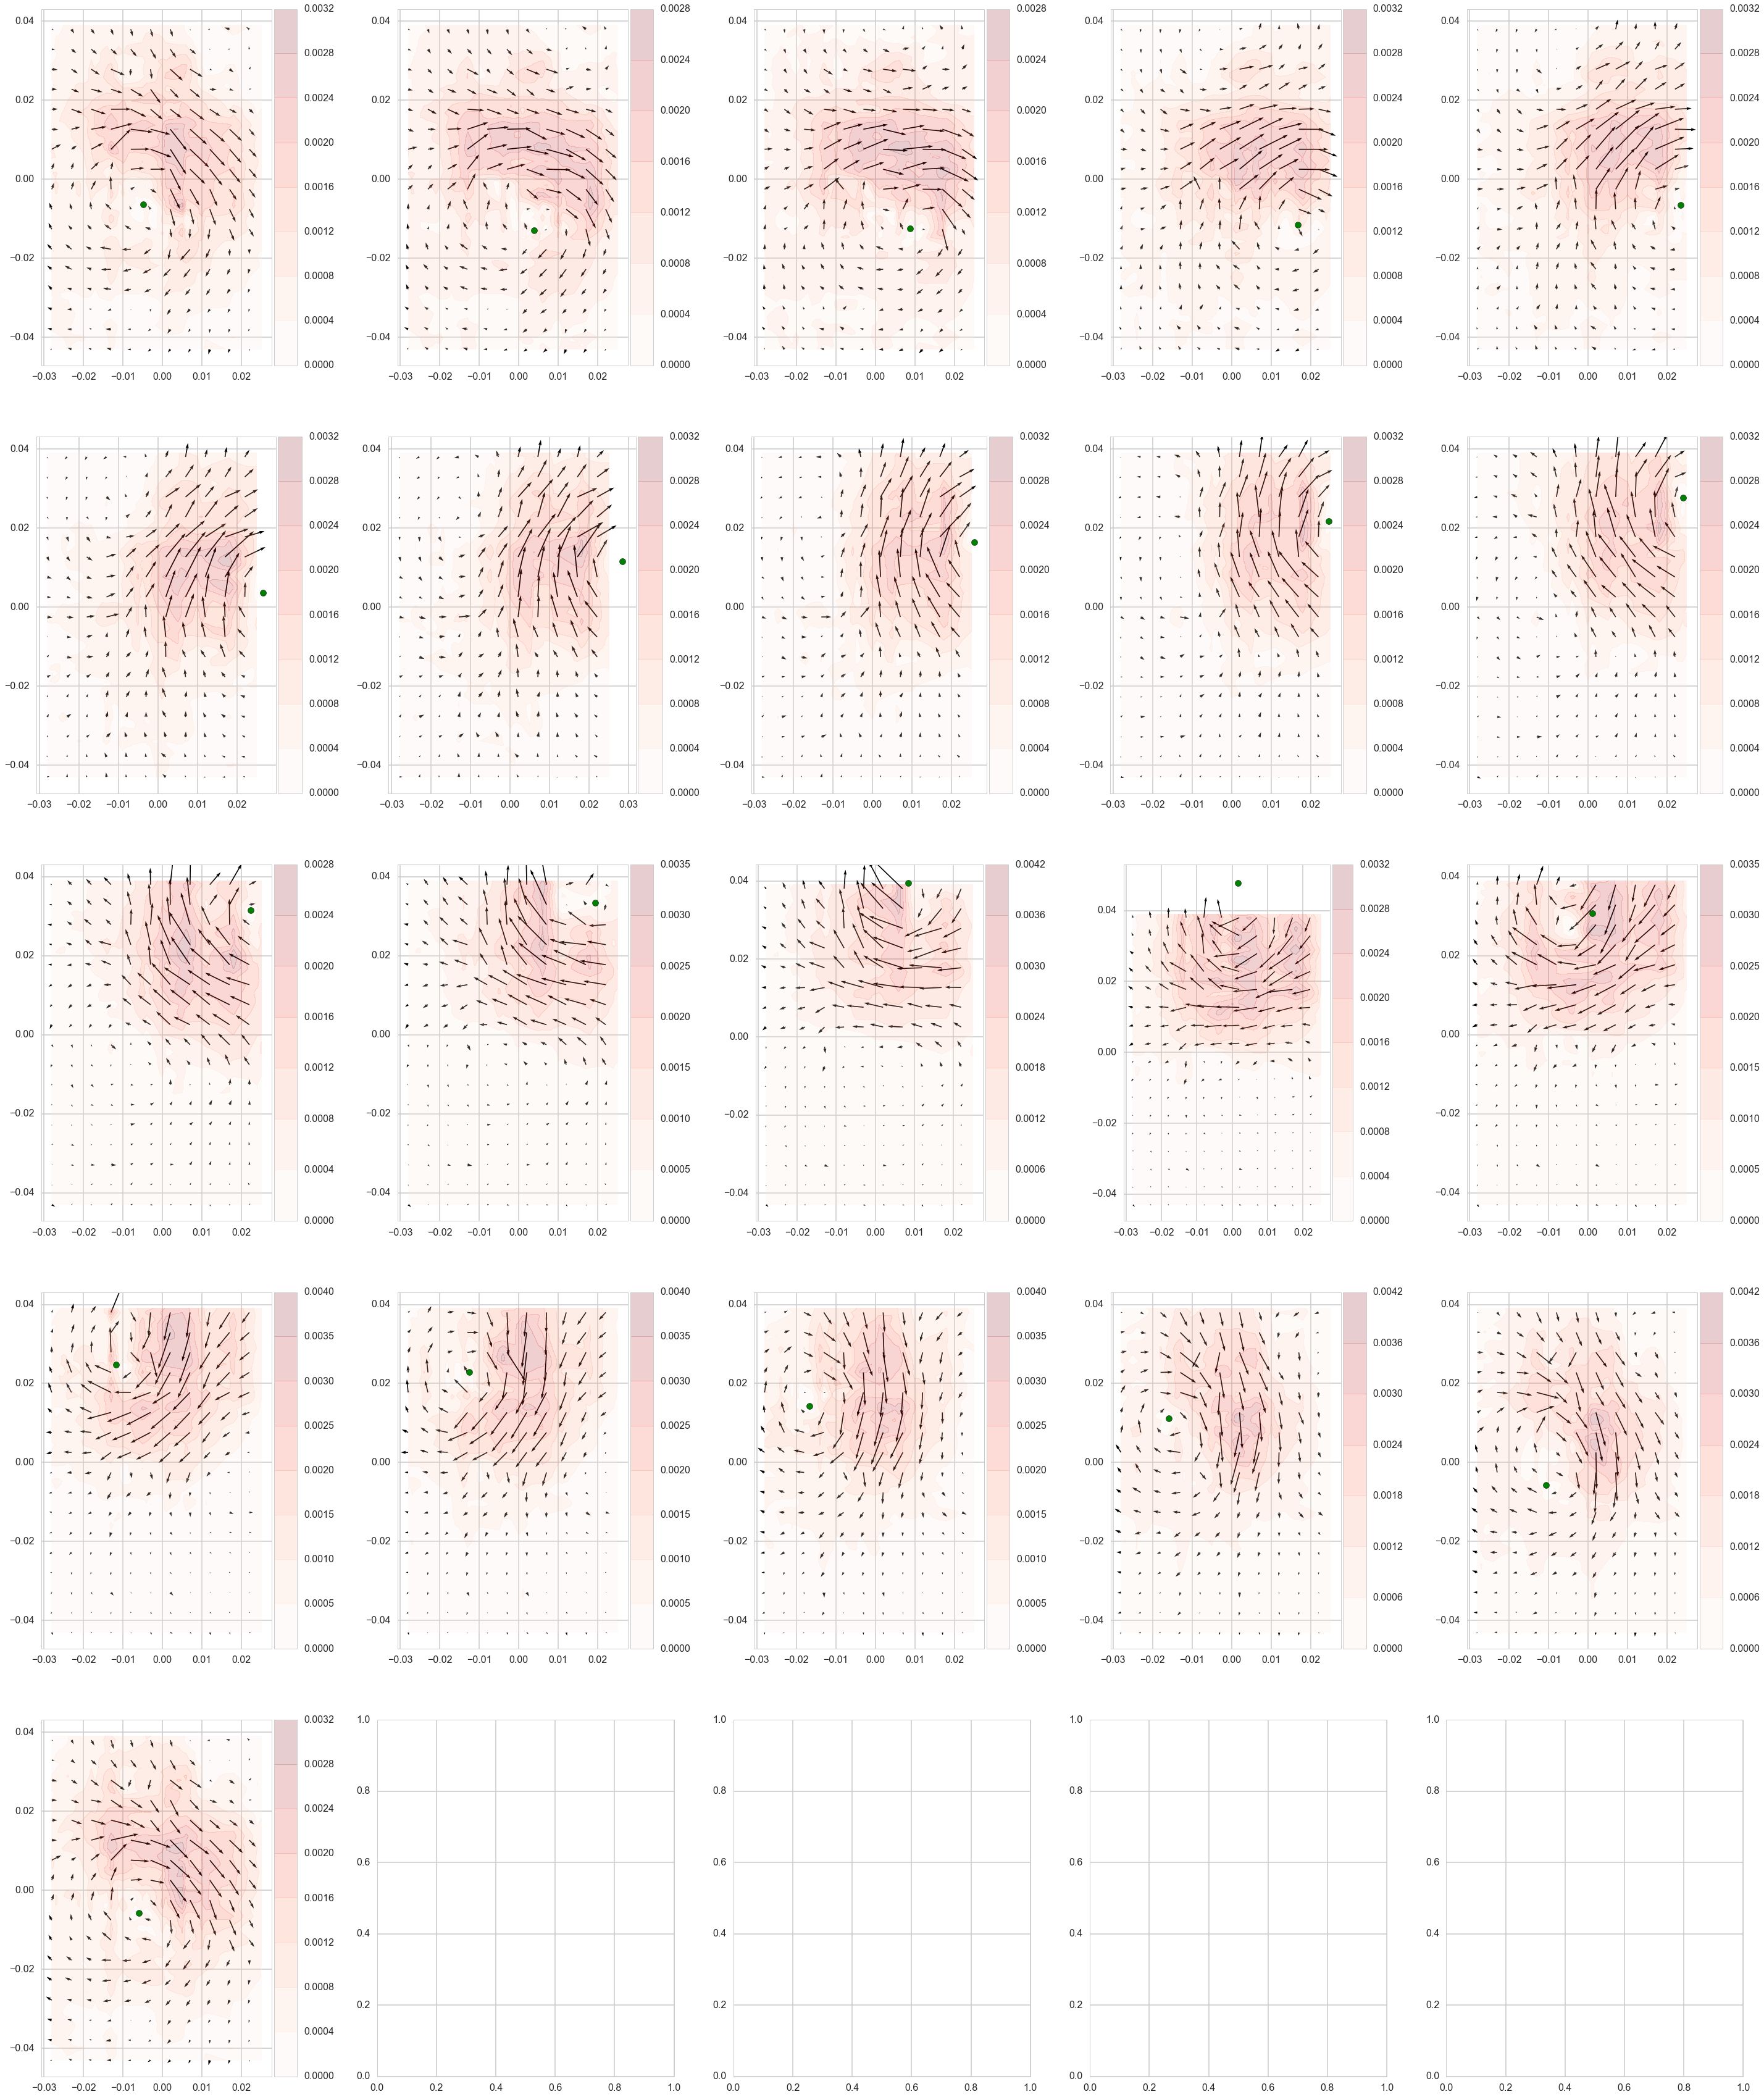

In [37]:
figure, axes = plt.subplots(5, 5, figsize=(50, 60))
for time_point in xrange(21):
    magnitude = np.sqrt(b_fields[time_point][0, :, :]**2 + b_fields[time_point][1, :, :]**2)
    axes[time_point/5][time_point%5].quiver(grid[0, :, :][::5, ::5], grid[1, :, :][::5, ::5], 
                                            b_fields[time_point][0, :, :][::5, ::5], 
                                            b_fields[time_point][1, :, :][::5, ::5]) 
    contour = axes[time_point/5][time_point%5].contourf(grid[0, :, :], grid[1, :, :], 
                                                        magnitude, alpha=0.2, cmap='Reds')
    divider = make_axes_locatable(axes[time_point/5][time_point%5])
    colorbar_axis = divider.append_axes("right", size="10%", pad=0.05)
    colorbar = plt.colorbar(contour, cax=colorbar_axis)
    axes[time_point/5][time_point%5].scatter(centroids[time_point][0], 
                                             centroids[time_point][1], c='g', s=100)
    axes[time_point/5][time_point%5].set_aspect('equal')

In [41]:
num_of_points = 10
xs = np.concatenate((np.linspace(centroids_0249[0][0], centroids_0302[0][0], num_of_points),
                     np.linspace(centroids_0302[0][0], centroids_0357[0][0], num_of_points),
                     np.linspace(centroids_0357[0][0], centroids_0416[0][0], num_of_points)))
ys = np.concatenate((np.linspace(centroids_0249[0][1], centroids_0302[0][1], num_of_points),
                     np.linspace(centroids_0302[0][1], centroids_0357[0][1], num_of_points),
                     np.linspace(centroids_0357[0][1], centroids_0416[0][1], num_of_points)))
zs = np.concatenate((np.linspace(0.249, 0.302, num_of_points),
                     np.linspace(0.302, 0.357, num_of_points),
                     np.linspace(0.357, 0.416, num_of_points)))
points = np.dstack((xs, ys, zs)).ravel()
ones = np.ones(points.shape)
points = points.tolist()
ones = ones.tolist()

In [49]:
prefix = "../output/2016-08-06/centroids"
ending = ".vtk"
for time_point in xrange(len(centroids_0249)):
    num_of_points = 70
    xs = np.concatenate((np.linspace(centroids_0249[time_point][0], centroids_0302[time_point][0], num_of_points),
                         np.linspace(centroids_0302[time_point][0], centroids_0357[time_point][0], num_of_points),
                         np.linspace(centroids_0357[time_point][0], centroids_0416[time_point][0], num_of_points)))
    ys = np.concatenate((np.linspace(centroids_0249[time_point][1], centroids_0302[time_point][1], num_of_points),
                         np.linspace(centroids_0302[time_point][1], centroids_0357[time_point][1], num_of_points),
                         np.linspace(centroids_0357[time_point][1], centroids_0416[time_point][1], num_of_points)))
    zs = np.concatenate((np.linspace(0.249, 0.302, num_of_points),
                         np.linspace(0.302, 0.357, num_of_points),
                         np.linspace(0.357, 0.416, num_of_points)))
    points = np.dstack((xs, ys, zs)).ravel()
    ones = np.ones(points.size/3)
    points = points.tolist()
    ones = ones.tolist()
    
    variables = (("centroids", 1, 1, ones),)
    visit_writer.WritePointMesh(prefix + str(time_point).zfill(4) + ending, 1, points, variables)

In [50]:
centroids = np.asarray(centroids)
np.savetxt('../output/2016-07-19/field_nulls.txt', centroids, header='magnetic field null positions in the z=0.249m plane,' + 
           'determined by fitting circles to integrated field lines starting at max magnitude and moving succesive' +
           'towards the center of circles.')